# CS 584 Assignment 2 -- MLP and Word Vectors

#### Name: (Matthew Halvorsen)
#### Stevens ID: (10444976)

## Part B: Word2Vec Coding Part (45 Points)

## In this assignment, you are required to follow the steps below:
1. Review the lecture slides.
2. Implement the data loading, preprocessing, tokenization, and word pair extraction.
3. Implement skip-gram and evaluation metrics with MLP.
5. Analysis the results in the Conlusion part.

**Before you start**
- Please read the code very carefully.
- Install these packages (jupyterlab, matplotlib, nltk, numpy, scikit-learn, tensorflow, tensorflow_addons) using the following command.
```console
pip install -r requirements.txt
```
- It's better to train the Tensorflow model with GPU and CUDA. If they are not available on your local machine, please consider Google CoLab. You can check `CoLab.md` in this assignments.
- You are **NOT** allowed to use other packages unless otherwise specified.
- You are **ONLY** allowed to edit the code between `# Start your code here` and `# End` for each block.

In [ ]:
# you may not run this cell after the first installation
!pip install -r requirements.txt

In [2]:
import tensorflow as tf


# If you are going to use GPU, make sure the GPU in in the output
tf.config.list_physical_devices('GPU')

[]

## 1. Data Processing (5 points)

In [3]:
import sys


def print_line(*args):
    """ Inline print and go to the begining of line
    """
    args1 = [str(arg) for arg in args]
    str_ = ' '.join(args1)
    print('\r' + str_, end='')

In [4]:
from typing import List, Tuple, Union

import numpy as np

### 1.1 Load data

In [5]:
import os
import pickle

# In this imdb review, each line is a sentence seperated by a space.
sentences = pickle.load(open(os.path.join('a2-data', 'imdb_review.pickle'), 'rb'))
print(sentences[:10])

['watching time chasers it obvious that it was made by a bunch of friends', 'maybe they were sitting around one day in film school and said hey let s pool our money together and make a really bad movie or something like that', 'what ever they said they still ended up making a really bad movie dull story bad script lame acting poor cinematography bottom of the barrel stock music etc', 'all corners were cut except the one that would have prevented this film s release', 'life s like that', 'i saw this film about years ago and remember it as being particularly nasty', 'i believe it is based on a true incident a young man breaks into a nurses home and rapes tortures and kills various women it is in black and white but saves the colour for one shocking shot at the end the film seems to be trying to make some political statement but it just comes across as confused and obscene avoid', 'minor spoilersin new york joan barnard elvire audrey is informed that her husband the archeologist arthur ba

### 1.3 Tokenization

In this section, you will implement a Tokenizer than can record all tokens in a vocabulary.

In [6]:
class Tokenizer:
    def __init__(self, sos_token='<s>', eos_token='</s>', pad_token='<pad>', unk_token='<unk>', mask_token='<mask>'):
        # Special tokens. Not used in Word2Vec
        self.sos_token = sos_token
        self.eos_token = eos_token
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.mask_token = mask_token
        
        self.vocab = { sos_token: 0, eos_token: 1, pad_token: 2, unk_token: 3, mask_token: 4 }  # token -> id
        self.inverse_vocab = { 0: sos_token, 1: eos_token, 2: pad_token, 3: unk_token, 4: mask_token }  # id -> token
        self.token_occurrence = { sos_token: 0, eos_token: 0, pad_token: 0, unk_token: 0, mask_token: 0 }  # token -> occurrence
        
    def __len__(self):
        """ A magic method that enable program to know the number of tokens by calling:
            ```python
            tokenizer = Tokenizer()
            num_tokens = len(tokenizer)
            ```
        """
        return len(self.vocab)
        
    def fit(self, sentences: List[str]):
        """ Fit the tokenizer using all sentences.
        1. Tokenize the sentence by splitting with spaces.
        2. Record the occurrence of all tokens
        3. Construct the token to index (self.vocab) map and the inversed map (self.inverse_vocab) based on the occurrence. The token with a higher occurrence has the smaller index
        
        Args:
            sentences: All sentences in the dataset.
        """
        n = len(sentences)
        for i, sentence in enumerate(sentences):
            if i % 100 == 0 or i == n - 1:
                print_line('Fitting Tokenizer:', (i + 1), '/', n)
            # Start your code here (Step 1 and 2)
            tokens = sentence.split()
            for tok in tokens:
                if tok in self.token_occurrence:
                    self.token_occurrence[tok] += 1
                else:
                    self.token_occurrence[tok] = 1
            # End
        print_line('\n')
        
        token_occurrence = sorted(self.token_occurrence.items(), key=lambda e: e[1], reverse=True)
        # Start your code here (Step 3, update self.vocab and self.inverse_vocab)
        self.vocab = {}
        self.inverse_vocab = {}

        for idx, (tok, _) in enumerate(token_occurrence):
            self.vocab[tok] = idx
            self.inverse_vocab[idx] = tok
        # End
        
        print('The number of distinct tokens:', len(self.vocab))
        
    def encode(self, sentences: List[str]) -> List[List[int]]:
        """ Encode the sentences into token ids
            Note: 1. if a token in a sentence does not exist in the fit encoder, we will use the <unk> token to replace it.
                  2. If the number of tokens in a sentence is less than two, we ignore this sentence.
        Args:
            sentences: Raw sentences
        Returns:
            sent_token_ids: A list of id list
        """
        n = len(sentences)
        sent_token_ids = []
        for i, sentence in enumerate(sentences):
            if i % 100 == 0 or i == n - 1:
                print_line('Encoding with Tokenizer:', (i + 1), '/', n)
            token_ids = []
            # Start your code (encode)
            tokens = sentence.split()
            if len(tokens) < 2:
                continue

            unk_id = self.vocab[self.unk_token]
            for tok in tokens:
                token_ids.append(self.vocab.get(tok, unk_id))

            sent_token_ids.append(token_ids)
            # End
        print_line('\n')
        return sent_token_ids

#### Test your implementation by running the following cell.

In [7]:
test_sentences = sentences[:2]
tokenizer = Tokenizer()
tokenizer.fit(test_sentences)
print()

token_occurrence = sorted(tokenizer.token_occurrence.items(), key=lambda e: e[1], reverse=True)
for token, occurrence in token_occurrence[:10]:
    print(token, ':', occurrence)
print()
sent_token_ids = tokenizer.encode(test_sentences)
print()
for test_sentence, token_ids in zip(test_sentences, sent_token_ids):
    sentence = [tokenizer.inverse_vocab[token] for token in token_ids]
    print(test_sentence, sentence, '\n')

Fitting Tokenizer: 2 / 2
The number of distinct tokens: 44

it : 2
that : 2
a : 2
and : 2
watching : 1
time : 1
chasers : 1
obvious : 1
was : 1
made : 1

Encoding with Tokenizer: 2 / 2

watching time chasers it obvious that it was made by a bunch of friends ['watching', 'time', 'chasers', 'it', 'obvious', 'that', 'it', 'was', 'made', 'by', 'a', 'bunch', 'of', 'friends'] 

maybe they were sitting around one day in film school and said hey let s pool our money together and make a really bad movie or something like that ['maybe', 'they', 'were', 'sitting', 'around', 'one', 'day', 'in', 'film', 'school', 'and', 'said', 'hey', 'let', 's', 'pool', 'our', 'money', 'together', 'and', 'make', 'a', 'really', 'bad', 'movie', 'or', 'something', 'like', 'that'] 



Encode all sentences

In [8]:
tokenizer = Tokenizer()
tokenizer.fit(sentences)
sent_token_ids = tokenizer.encode(sentences)

# Note: if you implement correctly, there will be about 100k tokens.

Fitting Tokenizer: 528199 / 528199
The number of distinct tokens: 102299
Encoding with Tokenizer: 528199 / 528199


In [9]:
print('max token number in a sentence:', max(map(lambda e: len(e), sent_token_ids)))
print('min token number in a sentence:', min(map(lambda e: len(e), sent_token_ids)))
print('avg token number in a sentence:', sum(map(lambda e: len(e), sent_token_ids)) / len(sent_token_ids))

max token number in a sentence: 767
min token number in a sentence: 2
avg token number in a sentence: 22.813560657451482


In [10]:
token_occurrence = sorted(tokenizer.token_occurrence.items(), key=lambda e: e[1], reverse=True)
for token, occurrence in token_occurrence[:10]:
    print(token, ':', occurrence)

the : 678333
and : 329979
a : 328341
of : 293903
to : 271514
is : 214380
it : 191411
in : 188920
i : 170761
this : 150693


## 2. Training Data Generation (10 Points)

### Positive Samples (5 Points)
In this section, you are required to generate the positive training data for skip-gram.

- Given a token sequence, for every center token, you need to use a window whose size is **2** to retrieve context words as positive pairs.
    
For example, given the token sequence "The quick brown fox jumps over the lazy dog .", when the center word is "fox", the context words are:
$$\text{The}~\underbrace{\text{quick brown}}_\text{context words}~\underbrace{\text{fox}}_{\text{center word}}~\underbrace{\text{jumps over}}_\text{context words}~\text{the lazy dog .}$$
We can generate four positive pairs: (fox, quick), (fox, brown), (fox, jumps), (fox, over).

In [11]:
import random


def positive_pairs_generator(sent_token_ids: List[List[int]], window_size: int = 2) -> np.ndarray:
    """ Generate positive pairs: (center word, context word)
    
    Args:
        sent_token_ids: List of token list. Each element is a token list (sentence)
        window_size: the context window size. You should retrieve window size context words in the left and window size context words in the right.
        
    Yield:
        center_word, context_word: a positive pair
        
    Note: this is a generator function which yields pairs. Do not return anything.
    """
    n = len(sent_token_ids)
    for t, token_ids in enumerate(sent_token_ids):
        if t % 100 == 0 or t == n - 1:
            print_line('Positive Pair Generation:', (t + 1), '/', n)
        for i, center_word in enumerate(token_ids):
            context_words = []
            # Start your code here
            # Append context words of center_word to context_words
            left = max(0, i - window_size)
            right = min(len(token_ids), i + window_size + 1)

            for j in range(left, right):
                if j != i:   # don't include the center word itself
                    context_words.append(token_ids[j])
            # End
            for context_word in context_words:
                yield center_word, context_word


def save_train_file(sent_token_ids: List[List[int]], window_size: int = 2):
    generator = positive_pairs_generator(sent_token_ids, window_size)
    buffer_size = 100000
    buffer = []
    count = 0
    with open(os.path.join('a2-data', 'word2vec_train_file.txt'), 'w') as train_file:
        for center_word, context_words in generator:
            count += 1
            line = f'{center_word} {context_words}\n'
            buffer.append(line)
            if len(buffer) == buffer_size:
                random.shuffle(buffer)
                train_file.writelines(buffer)
                buffer = []
        if len(buffer) > 0:
            train_file.writelines(buffer)
    print('\n')
    print(f'There are {count} pairs')
    return count

In [12]:
window_size = 2
num_samples = save_train_file(sent_token_ids, window_size)

# Note: if you implement correctly, there will be about 44M pairs.

Positive Pair Generation: 520373 / 520373

There are 44364006 pairs


### Negative Samples (5 Points)

We randomly select $K$ words from the vocabulary as negative samples.

In [13]:
def get_negative_samples(vocab_size: int, batch_size: int, negative_sample_num: int) -> np.ndarray:
    """ Generate negative words
    
    Args:
        vocab_size: number of tokens in the vocabulary
        batch_size: number of samples (center word) in a batch
        negative_sample_num: number of negative words sampled for a center word
        
    Return:
        negative_words: Shape of (batch_size x negative_sample_num)
        
    Note: 1. You should NOT sample special token in the vocabulary, i.e., the token ids range should be [5, vocab_size)
          2. Hint: See numpy.random.choice. Read carefully for each parameter of this function
    """
    negative_words = None
    # Start your code here
    negative_words = np.random.choice(
        np.arange(5, vocab_size),             # valid token ids (exclude special tokens 0-4)
        size=(batch_size, negative_sample_num),
        replace=True
    )
    # End
    return negative_words


def train_data_generator(batch_size, vocab_size, negative_sample_num):
    with open(os.path.join('a2-data', 'word2vec_train_file.txt')) as train_file:
        while True:
            batch_center_words, batch_context_words = [], []
            for line in train_file:
                center_word, context_word = line.strip().split()
                batch_center_words.append(int(center_word))
                batch_context_words.append(int(context_word))
                if len(batch_center_words) == batch_size:
                    negative_words = get_negative_samples(vocab_size, batch_size, negative_sample_num)
                    yield batch_center_words, batch_context_words, negative_words
                    batch_center_words, batch_context_words = [], []
            train_file.seek(0)
            if len(batch_center_words) > 0:
                real_batch_size = len(batch_center_words)
                negative_words = get_negative_samples(vocab_size, real_batch_size, negative_sample_num)
                yield batch_center_words, batch_context_words, negative_words
            

## 3. Skip-gram Model (20 Points)

- Loss: 10 Points
- Model: 10 Points

In [14]:
from tensorflow.keras import Model
from tensorflow.keras.losses import Loss

        
def negative_sampling_loss(center_embeddings, context_embeddings, negative_embeddings):
    """ Calculate the negative sampling loss
    
    Args:
        center_embeddings: v_c, (batch_size x embedding_dim)
        context_embeddings: u_o, (batch_size x embedding_dim)
        negative_embeddings: u_k, (batch_size x negative_sample_num x embedding_dim)
    """
    loss = 0
    # Start your code here
    # 1. Calculate positive dot product
    pos_dot = tf.reduce_sum(center_embeddings * context_embeddings, axis=1)
    # 2. loss for the positive pairs
    pos_loss = -tf.math.log(tf.sigmoid(pos_dot) + 1e-10)
    # 3. Calculate negative dot product
    neg_dot = tf.reduce_sum(tf.expand_dims(center_embeddings, axis=1) * negative_embeddings, axis=2)
    # 4. loss for the negative words
    neg_loss = -tf.reduce_sum(tf.math.log(tf.sigmoid(-neg_dot) + 1e-10), axis=1)
    # Hint: See tf.reduce_sum, tf.expand_dims, tf.reduce_mean for help
    loss = tf.reduce_mean(pos_loss + neg_loss)
    # End
    return loss


class SkipGram(Model):
    def __init__(self, vocab_size: int, embedding_dim: int):
        """ Skip-gram model.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        # Start your code here
        # Initialize embedding layers
        self.center_embeddings = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim
        )

        self.context_embeddings = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim
        )
        # Hint: See tf.keras.layers.Embedding

        # End
        
    def call(self, center_words, context_words, negative_words):
        """ Forward of the skip-gram model
        
        Args:
            center_words: tensor (batch_size, )
            context_words: tensor (batch_size, )
            negative_words: tensor (batch_size, negative_embeddings)
            
        Return:
            center_embeddings, context_embeddings, negative_embeddings: The input for the negative_sampling_loss.
        """
        # Start your code here
        center_embeddings = self.center_embeddings(center_words)          # (batch_size, embedding_dim)
        context_embeddings = self.context_embeddings(context_words)       # (batch_size, embedding_dim)
        negative_embeddings = self.context_embeddings(negative_words)     # (batch_size, negative_sample_num, embedding_dim)
        
        return center_embeddings, context_embeddings, negative_embeddings

In [15]:
vocab_size = len(tokenizer)
embedding_dim = 64
num_epoch = 2
batch_size = 1024
negative_sample_num = 5

In [16]:
model = SkipGram(vocab_size, embedding_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [17]:
n_batch = int(np.ceil(num_samples / batch_size))
train_gen = train_data_generator(batch_size, vocab_size, negative_sample_num)
for epoch in range(num_epoch):
    epoch_loss = 0.0
    for batch_idx in range(n_batch):
        batch = next(train_gen)
        real_batch_size = len(batch[0])
        batch = [tf.convert_to_tensor(d, tf.int64) for d in batch]

        with tf.GradientTape() as tape:
            output = model(*batch)
            loss = negative_sampling_loss(*output)

        if batch_idx % 10 == 0 or batch_idx == num_samples - 1:
            print_line(f'Epoch {epoch + 1} / {num_epoch} - Step {batch_idx + 1} / {n_batch} - loss: {loss:.4f}')
            
        trainable_vars = model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        optimizer.apply_gradients(zip(gradients, trainable_vars))
        epoch_loss += loss * real_batch_size
    print(f'\rEpoch {epoch + 1} / {num_epoch} - Step {n_batch} / {n_batch} - loss: {epoch_loss / num_samples:.4f}')

Epoch 1 / 2 - Step 43325 / 43325 - loss: 0.7397
Epoch 2 / 2 - Step 43325 / 43325 - loss: 0.6567


## 4. Visualization (5 Points)

In [18]:
# word_vecs = tf.concat([model.center_embeddings.weights[0], model.context_embeddings.weights[0]], axis=-1).numpy()
center_vecs = model.center_embeddings.weights[0].numpy()
center_vecs.shape

(102299, 64)

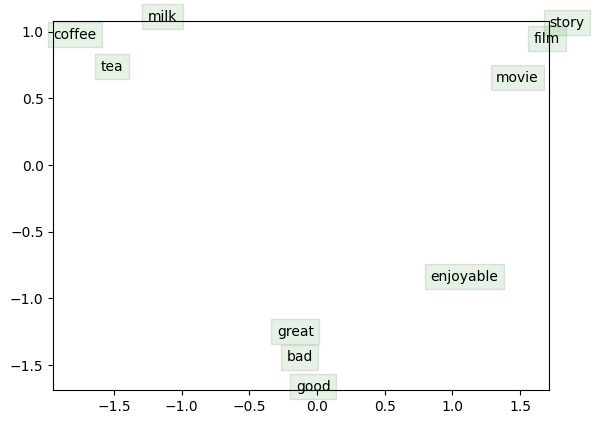

In [19]:
from matplotlib import pyplot as plt


visualize_words = [
    "movie", "film", "story",
    "good", "enjoyable", "great", "bad",
    "coffee", "tea", "milk"
]
visualize_idx = [tokenizer.vocab[word] for word in visualize_words]
visualize_vecs = center_vecs[visualize_idx, :]

temp = (visualize_vecs - np.mean(visualize_vecs, axis=0))
covariance = 1.0 / len(visualize_idx) * temp.T.dot(temp)
U, S, V = np.linalg.svd(covariance)
coord = temp.dot(U[:, 0:2])

for i in range(len(visualize_words)):
    plt.text(coord[i, 0], coord[i, 1], visualize_words[i],
             bbox=dict(facecolor='green', alpha=0.1))

plt.xlim((np.min(coord[:, 0]), np.max(coord[:, 0])))
plt.ylim((np.min(coord[:, 1]), np.max(coord[:, 1])))

plt.savefig('word_vectors.png')
plt.show()

In [20]:
def knn(vec, mat, k):
    """ Implement the KNN algorithm based on cosine similarity, which will be used for analysis.

        Args:
            vec: numpy ndarray, the target vector
            mat: numpy ndarray, a matrix contains all the vectors (each row is a vector)
            k: the number of the nearest neighbors you want to find.
            
        Return:
            indices: the k indices of the matrix's rows that are closest to the vec
    """
    indicies = []
    # Start your code here
    vec = vec.reshape(1, -1)  # (1, d)
    # Note: DO NOT use for loop to calculate the similarity between two vectors. You are required to vectorize the calculation.
    # cosine similarity = (A·B) / (||A|| ||B||)
    dot_products = mat @ vec.T                        # (n, 1)
    mat_norms = np.linalg.norm(mat, axis=1, keepdims=True)  # (n, 1)
    vec_norm = np.linalg.norm(vec)                    # scalar

    cosine_sim = (dot_products / (mat_norms * vec_norm + 1e-10)).flatten()  # (n,)
    # Hint: See np.argsort
    indices = np.argsort(cosine_sim)[-k:][::-1]
    # End
    
    return indices

In [21]:
for word in visualize_words:
    idx = tokenizer.vocab[word]
    vec = center_vecs[idx]
    indices = knn(vec, center_vecs, 10)
    closed_words = [tokenizer.inverse_vocab[i] for i in indices]
    print('Word: "{}" is close to {}'.format(word, closed_words))

Word: "movie" is close to ['movie', 'film', 'flick', 'sequel', 'stinker', 'miniseries', 'movies', 'documentary', 'programmes', 'travesty']
Word: "film" is close to ['film', 'movie', 'documentary', 'picture', 'miniseries', 'films', 'travesty', 'sequel', 'flick', 'stinker']
Word: "story" is close to ['story', 'storyline', 'concept', 'premise', 'plot', 'tale', 'stories', 'idea', 'ending', 'narrative']
Word: "good" is close to ['good', 'decent', 'nice', 'great', 'fine', 'bad', 'cool', 'excellent', 'perfect', 'alright']
Word: "enjoyable" is close to ['enjoyable', 'entertaining', 'watchable', 'disappointing', 'satisfying', 'engaging', 'worthwhile', 'exciting', 'forgettable', 'compelling']
Word: "great" is close to ['great', 'wonderful', 'amazing', 'fantastic', 'fine', 'excellent', 'terrific', 'incredible', 'nice', 'brilliant']
Word: "bad" is close to ['bad', 'terrible', 'awful', 'horrible', 'poor', 'good', 'lousy', 'stupid', 'sucks', 'ridiculous']
Word: "coffee" is close to ['coffee', 'beer'

## 5. Conclusion (5 Points)

Provide an analysis for all the results

Answer:
The goal of this type of model is to understand the context of words in a sequence by learning which words tend to appear near each other. One of the main challenges of these models is that a single word can have multiple meanings depending on the context it is used in. When looking at the semantic representation of the word vectors in 2D space, we see a positive trend overall. For example, milk, tea, and coffee are located close to each other, story, film, and movie are clustered together, and good, bad, and great are also near one another. This is a positive sign that the model has learned meaningful patterns from the dataset. It is important to note however that this 2D visualization is a reduced projection of a higher dimensional embedding space, so while it gives a good general idea of clustering, it may not perfectly represent all relationships in the original vector space. Another important observation is that word embeddings capture similarity in context rather than just similarity in meaning, which explains why words like good and bad appear close together even though they are opposites, since they are often used in similar sentence structures.

After running the embeddings through a KNN algorithm to find the 10 nearest neighbors of each word, we can see even more evidence of semantic understanding from the model. For example, the word movie is close to film, flick, sequel, stinker, miniseries, movies, documentary, programmes, and travesty. These words are all related either as synonyms or as words that could reasonably be used to describe or reference a movie, such as stinker. This is not perfect, but it shows strong signs that the model has learned useful contextual relationships. Another indication that the model has learned meaningful embeddings can be seen when looking at the nearest neighbors for coffee, which include beer, booze, cookies, whisky, drinking, pipe, pot, sweat, and liquor. Many of these words relate to drinking, food, or substances, which shows the model is associating coffee with a broader range of contexts. This suggests that the embedding for coffee may represent more diverse contextual usage compared to a word like movie, which tends to have more direct and consistent relationships. Overall, these results show that the model is learning positive semantic structure based on contextual similarity within the dataset. 